In [2]:
import os

from pyannote.core import Segment, Timeline, Annotation
from pyannote.metrics.diarization import DiarizationErrorRate
metric = DiarizationErrorRate()

In [3]:
def txt2annotation(path_txt, annotation=Annotation()):
    with open(path_txt, 'r') as f:
        for line in f:
            if len(line) == 0:
                continue
            start, end, speaker = line.split()
            annotation[Segment(float(start), float(end))] = speaker
        return annotation


# Primero, una prueba sencilla

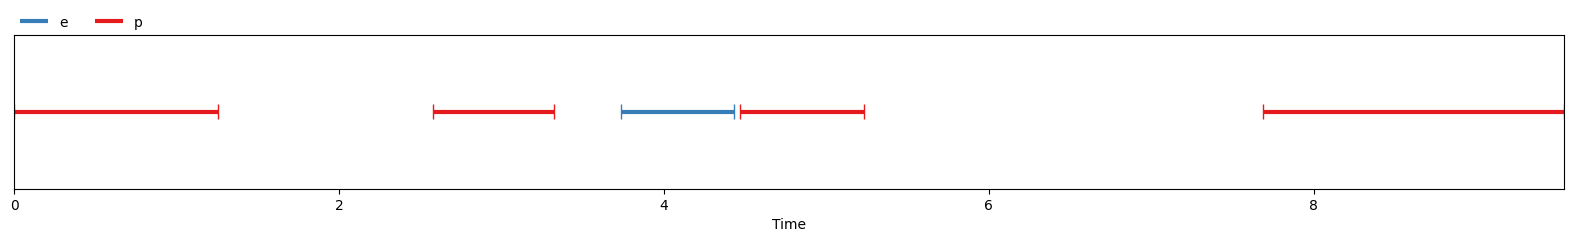

In [4]:
# reference annotation
reference_path = os.path.join('combined_database', 'reference', 'NP', 'CETRAM_AMG-0009_VocalSostenida.txt')
reference = txt2annotation(reference_path, annotation=Annotation(uri='test'))
reference

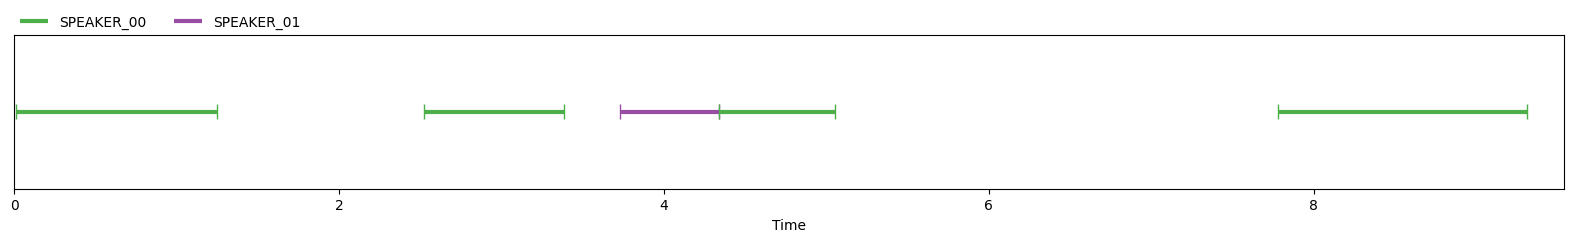

In [5]:
# hypothesis annotation
hypothesis_path = os.path.join('combined_database', 'hypothesis', 'NP', 'CETRAM_AMG-0009_VocalSostenida.txt')
hypothesis = txt2annotation(hypothesis_path, annotation=Annotation(uri='test'))
hypothesis

In [6]:
# DER
metric(reference, hypothesis, detailed=True)

/home/aleph/diariziation_error_rate/.env/lib/python3.10/site-packages/pyannote/metrics/utils.py:200: UserWarning: 'uem' was approximated by the union of 'reference' and 'hypothesis' extents.
  warnings.warn(


{'false alarm': 0.1664920000000003,
 'correct': 4.696732,
 'confusion': 0.09477599999999953,
 'missed detection': 0.5278220000000011,
 'total': 5.319330000000001,
 'diarization error rate': 0.1483438703746526}

In [7]:
# full report and reset metric
report = metric.report(display=True)
metric.reset()

      diarization error rate total correct correct false alarm false alarm missed detection missed detection confusion confusion
                           %                     %                       %                                 %                   %
item                                                                                                                            
test                   14.83  5.32    4.70   88.30        0.17        3.13             0.53             9.92      0.09      1.78
TOTAL                  14.83  5.32    4.70   88.30        0.17        3.13             0.53             9.92      0.09      1.78


# Ahora obtengamos un DER para todos los pares reference - hypothesis de la base combinada

In [16]:
# find all txt files in reference directory
reference_dir = os.path.join('combined_database', 'reference')
reference_files = [f for f in os.listdir(reference_dir) if f.endswith('.txt')]
# os walk to find all txt files in reference directory
count = 0
for root, dirs, files in os.walk(reference_dir):
    for file in files:
        if file.endswith('.txt'):
                reference_path = (os.path.join(root, file))
                annotation = Annotation(uri=file)
                reference = txt2annotation(reference_path, annotation)

                # find corresponding hypothesis file
                hypothesis_path = reference_path.replace('reference', 'hypothesis')
                annotation = Annotation(uri=file)
                hypothesis = txt2annotation(hypothesis_path, annotation)

                # compute DER
                metric(reference, hypothesis, detailed=True)

# cumulative report
print(abs(metric))
report = abs(metric.report(display=True))
report.to_csv('DER_report.csv')
metric.reset() # reset metric for next iteration

0.3078182464980635
                                        diarization error rate   total correct correct false alarm false alarm missed detection missed detection confusion confusion
                                                             %                       %                       %                                 %                   %
item                                                                                                                                                                
GERO_COH_114_LetraA.txt                                  57.41   27.87   13.61   48.83        1.74        6.24             7.23            25.95      7.03     25.22
GERO_COH_125_Fugu.txt                                    26.30   32.27   23.79   73.70        0.00        0.00             8.49            26.30      0.00      0.00
CETRAM_AMG-0031_RecuerdoAgradable.txt                    19.86   41.62   34.69   83.36        1.34        3.22             5.08            12.21      1.85  

In [14]:
# change the name of files in
# combined_database/hypothesis/XX, deleting the suffix "_diarization"

# find all txt files in hypothesis directory
hypothesis_dir = os.path.join('combined_database', 'hypothesis', 'JP')
for f in os.listdir(hypothesis_dir):
    if f.endswith('_diarization.txt'):
        os.rename(os.path.join(hypothesis_dir, f), os.path.join(hypothesis_dir, f.replace('_diarization', '')))